In [1]:
# IE598 Final Project Part2 - EconCycle
# Group member: Xiaohui Tu, Ying Qin, Xinya Liu, Jiaqi Su

In [16]:
# Import Packages and Data
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore') # Ignore warnings in the script

df = pd.read_csv('C:/Users/Xiaohui/Desktop/xhtu/UIUC/Course/IE598/Final/MLF_GP2_EconCycle.csv')
# Dataset contains 223 monthly observations of the US Treasury bond yield curve, the 
# commercial paper yield curve and the USPHCI Economic Activity Index

# Columns 'Date' and 'USPHCI' are not used in training and testing. 
# Features are 'T1Y Index', 'T2Y Index', 'T3Y Index', 'T5Y Index', 'T7Y Index', 'T10Y Index', 'CP1M', 'CP3M', 'CP6M', 'CP1M_T1Y', 'CP3M_T1Y' and 'CP6M_T1Y'
# Labels are 'PCT 3MO FWD', 'PCT 6MO FWD' and 'PCT 9MO FWD'

df = df.drop('Date', axis = 1) # This dataset will not be treated as time series, extract column 'Date'
df = df.drop('USPHCI', axis = 1) # Extract column 'USPHCI'
df = df.fillna(df.mean()) # Replace NaN with mean value, if any
df_X = df.iloc[:,0:12] #Seperate dataset into features and labels
df_y = df.iloc[:,12:15]

In [3]:
# EDA(general)
print(df.describe())

        T1Y Index   T2Y Index   T3Y Index   T5Y Index   T7Y Index  T10Y Index  \
count  223.000000  223.000000  223.000000  223.000000  223.000000  223.000000   
mean     8.030717    8.410673    8.563587    8.808655    8.979776    9.073498   
std      3.158575    2.954431    2.820405    2.647742    2.542686    2.447525   
min      3.180000    3.840000    4.170000    4.710000    5.050000    5.330000   
25%      5.735000    6.180000    6.410000    6.695000    6.965000    7.175000   
50%      7.670000    8.000000    8.130000    8.330000    8.520000    8.610000   
75%      9.840000   10.075000   10.375000   10.525000   10.640000   10.685000   
max     16.720000   16.460000   16.220000   15.930000   15.650000   15.320000   

             CP1M        CP3M        CP6M    CP1M_T1Y    CP3M_T1Y    CP6M_T1Y  \
count  223.000000  223.000000  223.000000  223.000000  223.000000  223.000000   
mean     7.942197    7.936906    7.892780    0.981765    0.983524    0.982666   
std      3.405098    3.3293

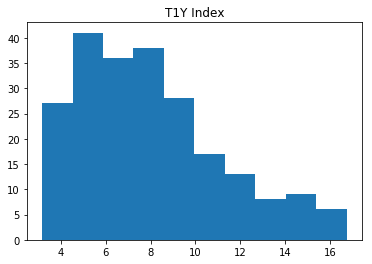

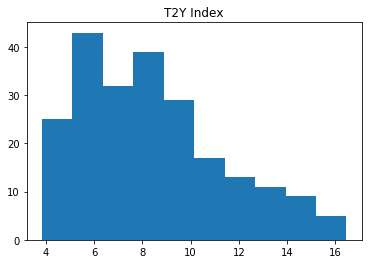

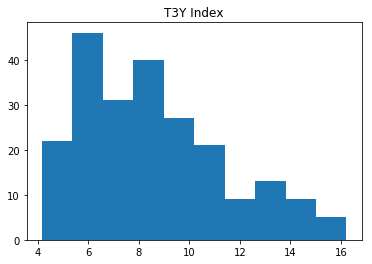

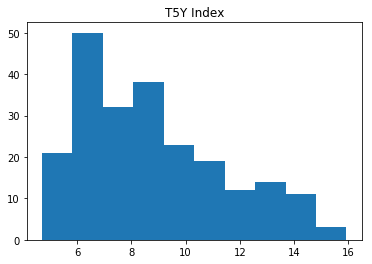

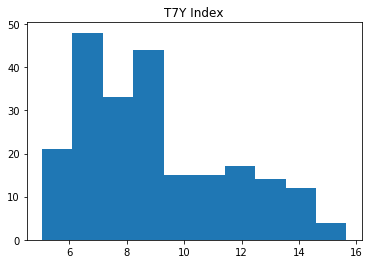

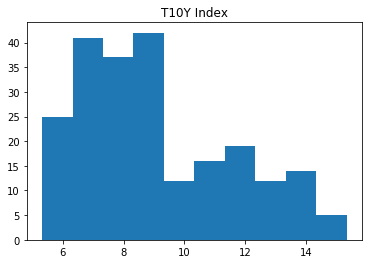

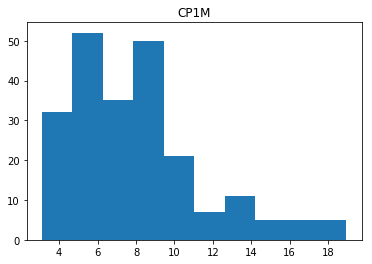

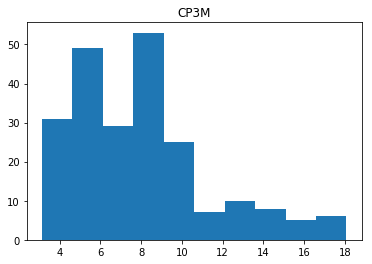

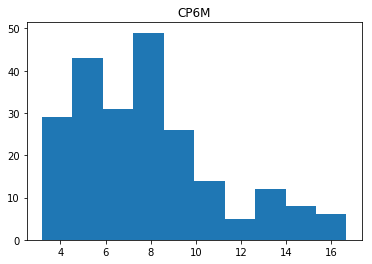

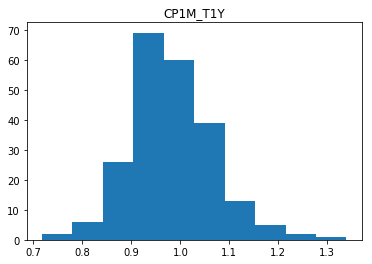

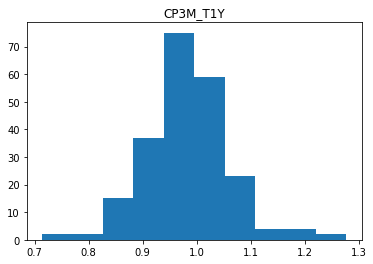

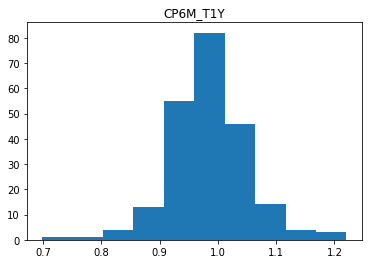

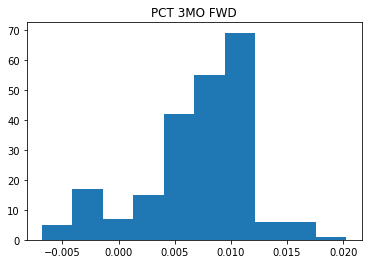

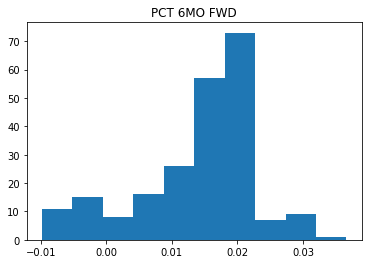

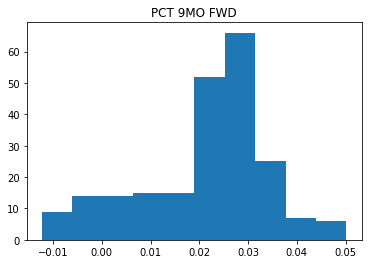

In [15]:
# EDA(graphs)
# Histograms
import matplotlib.pyplot as plt

for k in df.keys():
    _ = plt.hist(df[k])
    plt.title(k)
    plt.show()

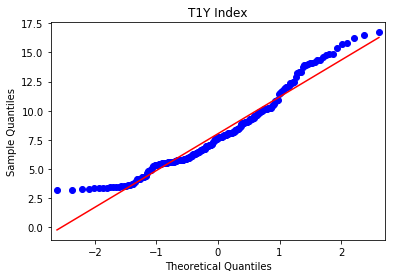

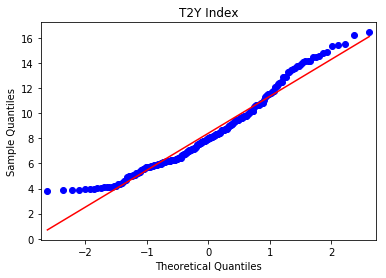

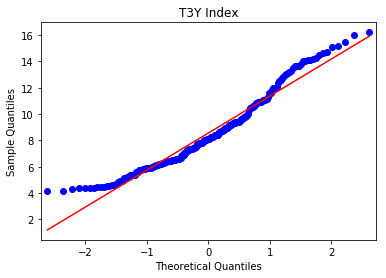

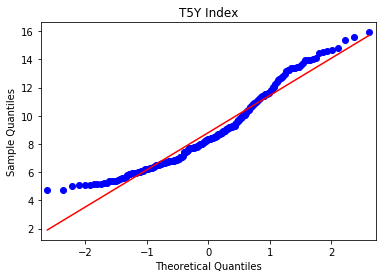

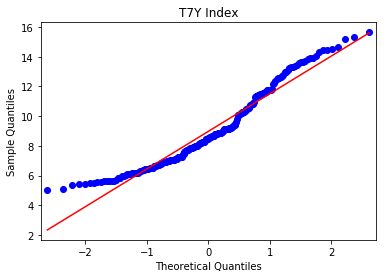

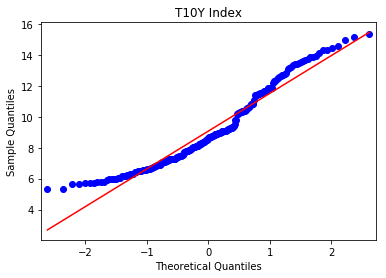

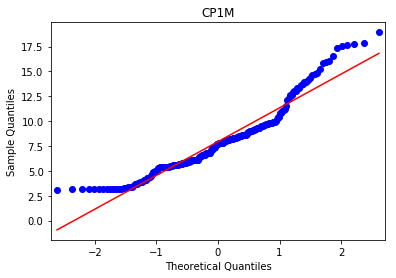

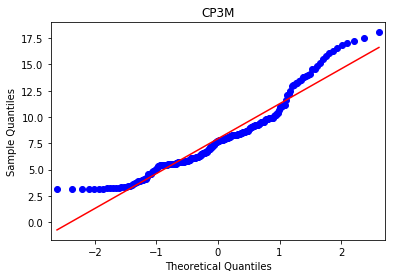

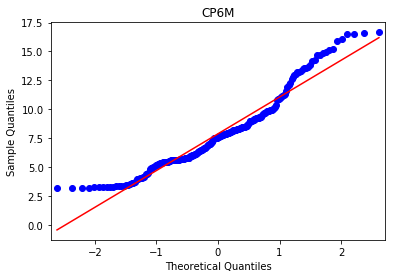

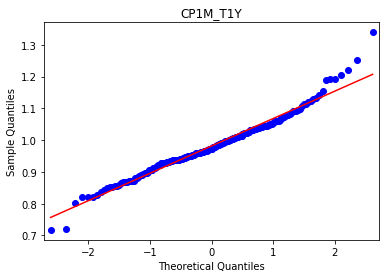

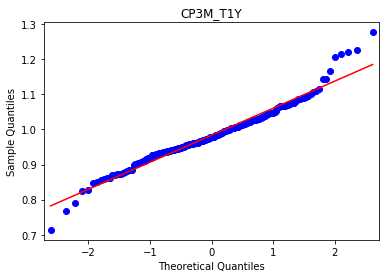

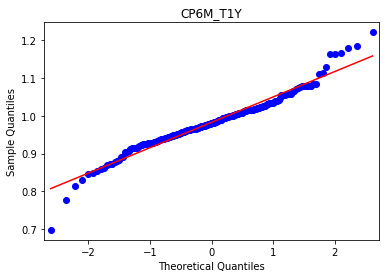

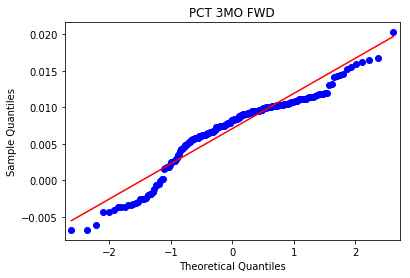

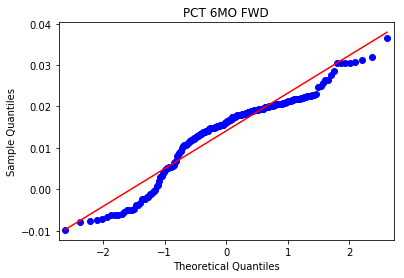

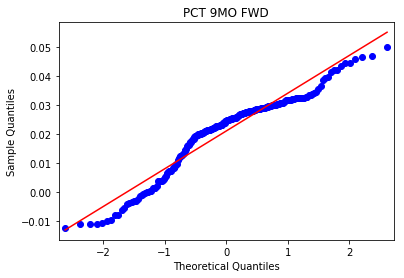

In [5]:
# QQ-plot
from statsmodels.graphics.gofplots import qqplot

for k in df.keys():
    _ = qqplot(df[k], line = 's')
    plt.title(k)
    plt.show()

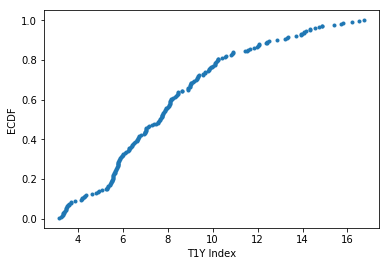

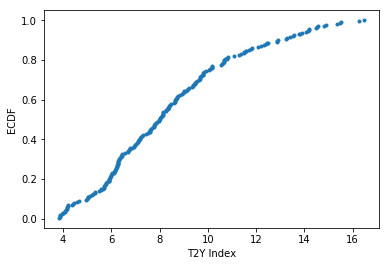

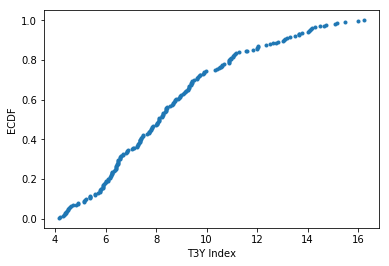

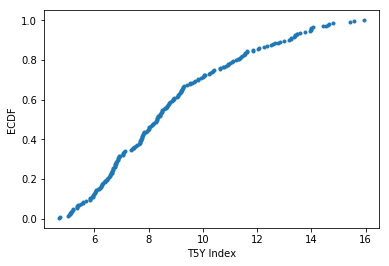

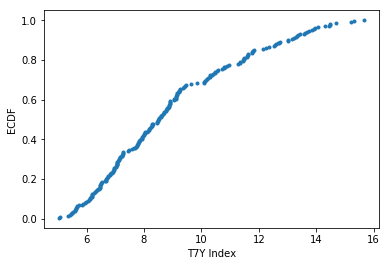

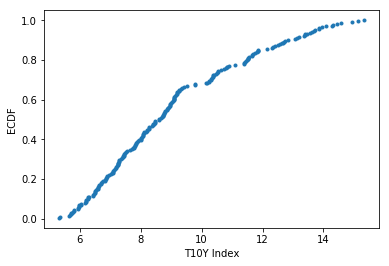

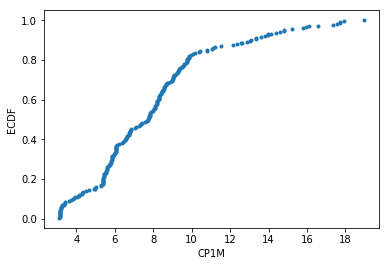

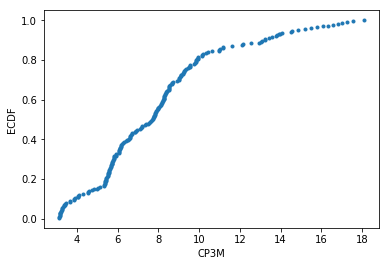

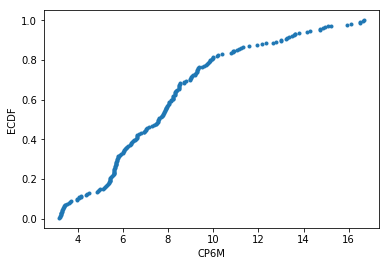

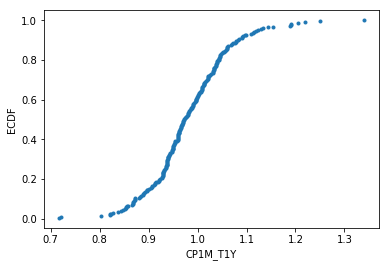

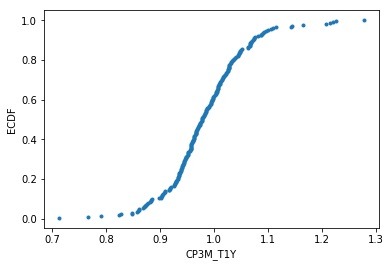

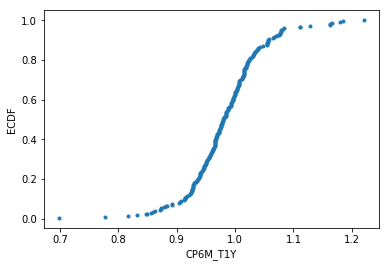

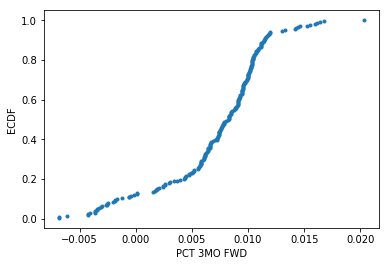

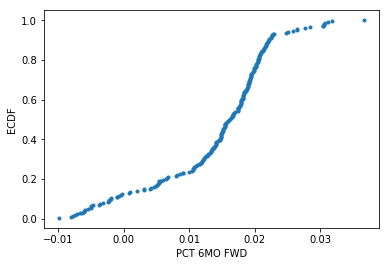

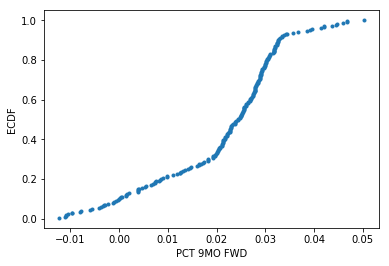

In [6]:
# ECDF
for k in df.keys():
    x = np.sort(df[k])
    y = np.arange(1, len(x) + 1) / len(x)
    _ = plt.plot(x, y, marker = '.', linestyle = 'none')
    _ = plt.xlabel(k)
    _ = plt.ylabel('ECDF')
    plt.show()

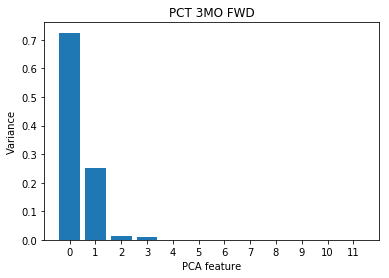

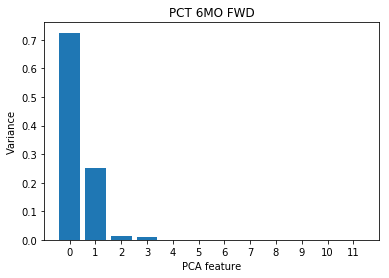

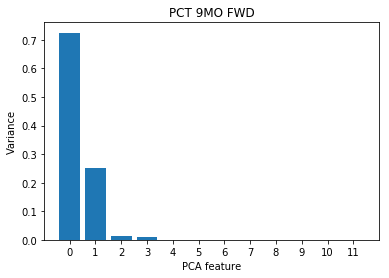

In [7]:
# Preprocessing
from sklearn import preprocessing
from sklearn.decomposition import PCA

X = df.loc[:, 'T1Y Index' : 'CP6M_T1Y']
Y3 = df['PCT 3MO FWD']
Y6 = df['PCT 6MO FWD']
Y9 = df['PCT 9MO FWD']
X_scaled = preprocessing.scale(X)

pca_all = PCA()
a = 3 # Variable in 'for loop' to count the number of months

for i in [Y3, Y6, Y9]:
    pca_all.fit(X_scaled, i)
    features = range(pca_all.n_components_)
    plt.bar(features, pca_all.explained_variance_ratio_)
    plt.title('PCT ' + str(a) + 'MO FWD')
    plt.xlabel('PCA feature')
    plt.ylabel('Variance')
    plt.xticks(features)
    _ = plt.show()
    a += 3

In [8]:
# PCA(n = 4) for linear regression
pca_4 = PCA(n_components = 4)
a = 3 # Variable in 'for loop' to count the number of months

for i in [Y3, Y6, Y9]:
    pca_4.fit(X_scaled, i)
    features = range(pca_4.n_components_)
    print('The explained variance ratio of the 4 components of PCT ' + str(a) + ' MO FWD is %.4f, %.4f, %.4f, %.4f' % (pca_4.explained_variance_ratio_[0], pca_4.explained_variance_ratio_[1], pca_4.explained_variance_ratio_[2], pca_4.explained_variance_ratio_[3]))
    a += 3    

The explained variance ratio of the 4 components of PCT 3 MO FWD is 0.7250, 0.2505, 0.0145, 0.0085
The explained variance ratio of the 4 components of PCT 6 MO FWD is 0.7250, 0.2505, 0.0145, 0.0085
The explained variance ratio of the 4 components of PCT 9 MO FWD is 0.7250, 0.2505, 0.0145, 0.0085


In [9]:
# Modeling
# LinearRegression(with PCA)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time

a = 3 # Variable in 'for loop' to count the number of months

for i in [Y3, Y6, Y9]:
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(pca_4.transform(X_scaled), i, test_size = 0.15, random_state = 20)
    start = time.time()    
    reg = LinearRegression()
    reg.fit(X_train_pca, y_train)
    y_pred = reg.predict(X_test_pca)
    cv_scores = cross_val_score(reg, X_train_pca, y_train, cv = 10)
    end = time.time()
    runtime = end - start

    print('Linear Regression: PCT ' + str(a) + 'MO FWD')
    print('R^2(train): %.4f'% (reg.score(X_train_pca,y_train)))
    print('R^2(test): %.4f' % (reg.score(X_test_pca,y_test)))
    print('RMSE(test): %.4f' % (np.sqrt(mean_squared_error(y_test, y_pred))))
    print('Average 10-Fold CV Score: %.4f' % (np.mean(cv_scores)))
    print('Run time: %.4fs\n' % (runtime))
    
    a += 3

Linear Regression: PCT 3MO FWD
R^2(train): 0.2099
R^2(test): 0.1210
RMSE(test): 0.0039
Average 10-Fold CV Score: 0.0493
Run time: 0.1470s

Linear Regression: PCT 6MO FWD
R^2(train): 0.2726
R^2(test): 0.1672
RMSE(test): 0.0065
Average 10-Fold CV Score: 0.0785
Run time: 0.0160s

Linear Regression: PCT 9MO FWD
R^2(train): 0.3356
R^2(test): 0.0688
RMSE(test): 0.0092
Average 10-Fold CV Score: 0.1499
Run time: 0.0140s



In [17]:
# Lasso Regression with Hyperparameter Tuning
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

a = 3 # Variable in 'for loop' to count the number of months

for i in [Y3, Y6, Y9]:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, i, test_size = 0.15, random_state = 20)
    start = time.time()
    lasso = Lasso()
    param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.5, 0.7, 0.9, 1, 5, 10]}
    lasso_reg = GridSearchCV(lasso, param_grid, cv = 5)
    lasso_reg.fit(X_train, y_train)
    end = time.time()
    run_time = end - start
    
    print('Lasso Regression: PCT ' + str(a) + 'MO FWD')
    print('Best alpha for Lasso: {}' .format(lasso_reg.best_params_))
    print('Best score(R^2) for Lasso: %.4f' % (lasso_reg.best_score_))
    print('Run time: %.4fs\n' % (runtime))

    a += 3

Lasso Regression: PCT 3MO FWD
Best alpha for Lasso: {'alpha': 0.0001}
Best score(R^2) for Lasso: 0.0698
Run time: 0.0140s

Lasso Regression: PCT 6MO FWD
Best alpha for Lasso: {'alpha': 0.0001}
Best score(R^2) for Lasso: 0.1551
Run time: 0.0140s

Lasso Regression: PCT 9MO FWD
Best alpha for Lasso: {'alpha': 0.0001}
Best score(R^2) for Lasso: 0.2247
Run time: 0.0140s



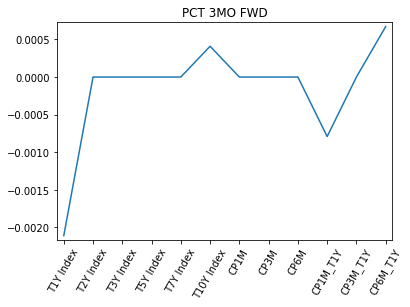

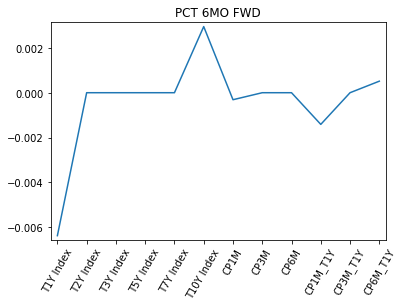

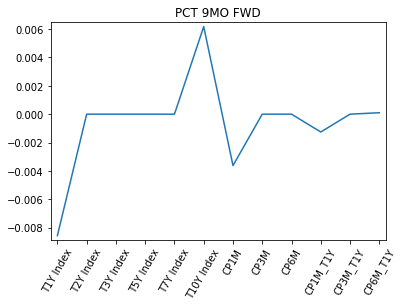

In [11]:
# Lasso Plot
lasso = Lasso(alpha = 0.0001)
a = 3 # Variable in 'for loop' to count the number of months

for i in [Y3, Y6, Y9]:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, i, test_size = 0.15, random_state = 20)
    lasso.fit(X_train, y_train)
    lasso_coef = lasso.fit(X_train, y_train).coef_
    
    plt.plot(range(X_scaled.shape[1]), lasso_coef)
    plt.xticks(range(X_scaled.shape[1]), X.columns, rotation = 60)
    plt.title('PCT ' + str(a) + 'MO FWD')
    plt.margins(0.02)
    _ = plt.show()
    
    a += 3

In [18]:
# Ridge Regression with Hyperparameter Tuning

from sklearn.linear_model import Ridge

a = 3 # Variable in 'for loop' to count the number of months

for i in [Y3, Y6, Y9]:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, i, test_size = 0.15, random_state = 20)
    start = time.time()
    ridge = Ridge()
    param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.5, 0.7, 0.9, 1, 5, 10]}
    ridge_reg = GridSearchCV(ridge, param_grid, cv = 5)
    ridge_reg.fit(X_train, y_train)
    end = time.time()
    run_time = end - start
    
    print('Ridge Regression: PCT ' + str(a) + 'MO FWD')
    print('Best alpha for Ridge: {}' .format(ridge_reg.best_params_))
    print('Best score(R^2) for Ridge: %.4f' % (ridge_reg.best_score_))
    print('Run time: %.4fs\n' % (runtime))

    a += 3

Ridge Regression: PCT 3MO FWD
Best alpha for Ridge: {'alpha': 0.01}
Best score(R^2) for Ridge: 0.1064
Run time: 0.0140s

Ridge Regression: PCT 6MO FWD
Best alpha for Ridge: {'alpha': 5}
Best score(R^2) for Ridge: 0.1653
Run time: 0.0140s

Ridge Regression: PCT 9MO FWD
Best alpha for Ridge: {'alpha': 0.01}
Best score(R^2) for Ridge: 0.2493
Run time: 0.0140s



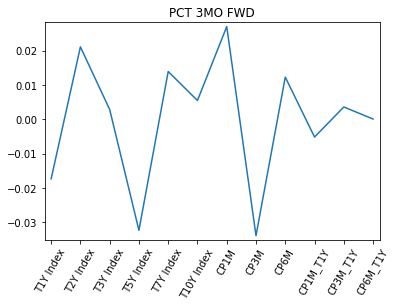

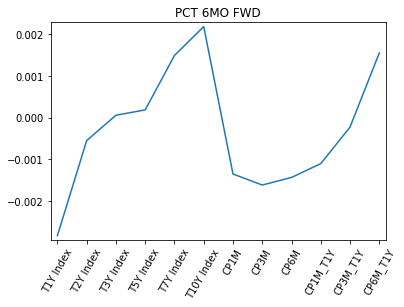

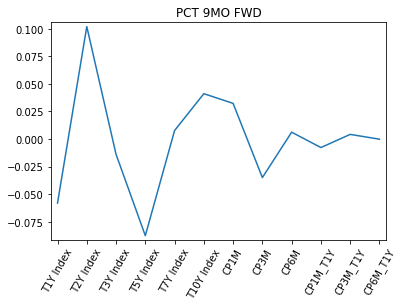

In [13]:
# Ridge Plot
# Y3(alpha = 0.01)
ridge = Ridge(alpha = 0.01)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y3, test_size = 0.15, random_state = 20)
ridge.fit(X_train, y_train)
ridge_coef = ridge.fit(X_train, y_train).coef_
    
plt.plot(range(X_scaled.shape[1]), ridge_coef)
plt.xticks(range(X_scaled.shape[1]), X.columns, rotation = 60)
plt.title('PCT 3MO FWD')
plt.margins(0.02)
_ = plt.show()
    
# Y6(alpha = 5)
ridge = Ridge(alpha = 5)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y6, test_size = 0.15, random_state = 20)
ridge.fit(X_train, y_train)
ridge_coef = ridge.fit(X_train, y_train).coef_
    
plt.plot(range(X_scaled.shape[1]), ridge_coef)
plt.xticks(range(X_scaled.shape[1]), X.columns, rotation = 60)
plt.title('PCT 6MO FWD')
plt.margins(0.02)
_ = plt.show()

# Y9(alpha = 0.01)
ridge = Ridge(alpha = 0.01)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y9, test_size = 0.15, random_state = 20)
ridge.fit(X_train, y_train)
ridge_coef = ridge.fit(X_train, y_train).coef_
    
plt.plot(range(X_scaled.shape[1]), ridge_coef)
plt.xticks(range(X_scaled.shape[1]), X.columns, rotation = 60)
plt.title('PCT 9MO FWD')
plt.margins(0.02)
_ = plt.show()

In [53]:
# Ensembling
# Bagging
from sklearn.ensemble import BaggingRegressor

a = 3 # Variable in 'for loop' to count the number of months

for i in [Y3, Y6, Y9]:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, i, test_size = 0.15, random_state = 20)
    start = time.time()
    br = BaggingRegressor(n_estimators = 1000, oob_score = True,) # base estimator is decision tree
    br.fit(X_train, y_train)
    y_pred = br.predict(X_test)
    end = time.time()
    run_time = end - start
    
    print('Bagging Regression: PCT ' + str(a) + 'MO FWD')
    print('R^2(train): %.4f'% (br.score(X_train,y_train)))
    print('R^2(test): %.4f' % (br.score(X_test, y_test)))
    print('Out-of-bag score: %.4f' % (br.oob_score_))
    print('Run time: %.4fs\n' % (runtime))

    a += 3

Bagging Regression: PCT 3MO FWD
R^2(train): 0.9356
R^2(test): 0.1137
Out-of-bag score: 0.5232
Run time: 1.3744s

Bagging Regression: PCT 6MO FWD
R^2(train): 0.9566
R^2(test): 0.2493
Out-of-bag score: 0.6840
Run time: 1.3744s

Bagging Regression: PCT 9MO FWD
R^2(train): 0.9676
R^2(test): 0.3532
Out-of-bag score: 0.7618
Run time: 1.3744s



In [47]:
# Boosting
from sklearn.ensemble import GradientBoostingRegressor

a = 3 # Variable in 'for loop' to count the number of months

for i in [Y3, Y6, Y9]:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, i, test_size = 0.15, random_state = 20)
    start = time.time()
    gb = GradientBoostingRegressor(max_depth = 4, n_estimators = 1000)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    cv_scores = cross_val_score(gb, X_train, y_train, cv = 10)
    end = time.time()
    runtime = end - start

    print('GradientBoosting Regression: PCT ' + str(a) + 'MO FWD')
    print('R^2(train): %.4f'% (gb.score(X_train,y_train)))
    print('R^2(test): %.4f' % (gb.score(X_test,y_test)))
    print('RMSE(test): %.4f' % (np.sqrt(mean_squared_error(y_test, y_pred))))
    print('Average 10-Fold CV Score: %.4f' % (np.mean(cv_scores)))
    print('Run time: %.4fs\n' % (runtime))
    
    a += 3

GradientBoosting Regression: PCT 3MO FWD
R^2(train): 0.9959
R^2(test): 0.1647
RMSE(test): 0.0038
Average 10-Fold CV Score: 0.3452
Run time: 1.4174s

GradientBoosting Regression: PCT 6MO FWD
R^2(train): 0.9989
R^2(test): 0.0944
RMSE(test): 0.0068
Average 10-Fold CV Score: 0.4605
Run time: 1.4704s

GradientBoosting Regression: PCT 9MO FWD
R^2(train): 0.9995
R^2(test): 0.3530
RMSE(test): 0.0077
Average 10-Fold CV Score: 0.6794
Run time: 1.5204s



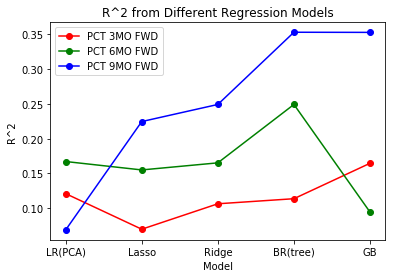

In [64]:
# Plot R^2 Comparsion

x = ['LR(PCA)', 'Lasso', 'Ridge', 'BR(tree)', 'GB']
y3 = [0.1210, 0.0698, 0.1064, 0.1137, 0.1647]
y6 = [0.1672, 0.1551, 0.1653, 0.2493, 0.0944]
y9 = [0.0688, 0.2247, 0.2493, 0.3532, 0.3530]

l1 = plt.plot(x, y3, 'ro-', label = 'PCT 3MO FWD')
l2 = plt.plot(x, y6, 'go-', label = 'PCT 6MO FWD')
l3 = plt.plot(x, y9, 'bo-', label = 'PCT 9MO FWD')
plt.title('R^2 from Different Regression Models')
plt.xlabel('Model')
plt.ylabel('R^2')
plt.legend()
_ = plt.show()

In [65]:
print('Group members are: Xiaohui Tu, Ying Qin, Jiaqi Su, Xinya Liu.')
print('NetIDs are: xtu5,')
print('We hereby certify that we have read the University policy on Academic Integrity and that we are not in violation.')

Group members are: Xiaohui Tu, Ying Qin, Jiaqi Su, Xinya Liu.
NetIDs are: xtu5,
We hereby certify that we have read the University policy on Academic Integrity and that we are not in violation.
